## Find total number of alarms of priority 1, 2 and 3
Input:
- Events last 12 hours
- Granularity of 10 minutes
Output:
- Total number of alarms (of each priority) in each 10 min time slot
- For each 10 min slot; percentage of 12-hour average

In [1]:
from initialize import initialize_client
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import re

In [2]:
client = initialize_client("prod", True)

### 1. Filter for last 12 hours

In [43]:
now = pd.to_datetime(pd.Timestamp.now()) - pd.Timedelta(hours=16)
twelve_hours_ago = pd.to_datetime(now - pd.Timedelta(hours=40), unit="ms")
start_time_sec = (twelve_hours_ago - datetime(1970, 1, 1)).total_seconds() * 1000 # convert from "seconds since epoch" to "milliseconds since epoch"
end_time_sec = (now - datetime(1970, 1, 1)).total_seconds() * 1000

In [50]:
def df_with_metadata(df):
    df_metadata = pd.DataFrame(df["metadata"].to_list())
    df_metadata["external_id"] = df["external_id"].values
    df = df.drop(["metadata"], axis=1)
    df = pd.merge(df, df_metadata, on=["external_id"])
    df["asset_ids"] = df["asset_ids"].apply(lambda x: x[0] if isinstance(x,list) else x)
    return df

In [53]:
opc_ua_val_id = 140572846698809
priority_1 = [*list(range(901,907)), 909]
priority_2 = [*list(range(801,807)), 809]
priority_3 = [*list(range(701,707)), 709]

alarm_events = pd.DataFrame()
for pri in (priority_1 + priority_2 + priority_3):
    # Extract from column "Severity"
    pri_events_A = client.events.list(data_set_ids=opc_ua_val_id, metadata={"Severity":pri}, limit=-1,
                                    start_time={"min":int(start_time_sec), "max":int(end_time_sec)}).to_pandas()
    if not pri_events_A.empty:
        pri_events_A = df_with_metadata(pri_events_A)
    # Extract from column "severity"
    pri_events_B = client.events.list(data_set_ids=opc_ua_val_id, metadata={"severity":pri}, limit=-1,
                                    start_time={"min":int(start_time_sec), "max":int(end_time_sec)}).to_pandas()
    if not pri_events_B.empty:
        pri_events_B = df_with_metadata(pri_events_B)

    pri_events = (pd.concat([pri_events_A, pri_events_B], ignore_index=True, sort=False)).drop_duplicates()
    alarm_events = pd.concat([alarm_events, pri_events])

print(f"Number of alarm events last 12 hours: {len(alarm_events)}")
# pd.to_datetime(1696482499768/1000, unit="ms") # format is in MILLISECONDS since epoch, not SECONDS since epoch

Number of alarm events last 12 hours: 9848


<bound method DataFrame.drop of                             external_id      data_set_id     start_time  \
0    opcua_val_T/0DGQ6DF0q4bUp+VGNqjg==  140572846698809  1697533363623   
1    opcua_val_ZovgfWbjMEWFoWd5/pWnLA==  140572846698809  1697533393623   
2    opcua_val_iwYsVbXZNkyIhQ8ia2lRRA==  140572846698809  1697535100623   
3    opcua_val_6FydoEoU+EeiXigJCaCfvQ==  140572846698809  1697535113623   
4    opcua_val_X8fxqd744kGtwgFbND4Icw==  140572846698809  1697634294274   
..                                  ...              ...            ...   
752  opcua_val_7EElpkz0BUmY6WeXRrNykg==  140572846698809  1697674378425   
753  opcua_val_QzHo8IM4EkCgPKgEFvozGA==  140572846698809  1697674379425   
754  opcua_val_itQoKwErF0WG2fdrkwEb0w==  140572846698809  1697674384470   
755  opcua_val_y1+dz+CSaE2h9LTV4LT5AQ==  140572846698809  1697674453788   
756  opcua_val_1MJCBuW+f0KtqtlpvxPrjA==  140572846698809  1697674858545   

          end_time     type_x             description     asset_ids

In [57]:
# Check that all events are within desired time frame
assert(min(alarm_events["start_time"]) >= start_time_sec and
       max(alarm_events["start_time"]) <= end_time_sec)

In [15]:
alarm_metadata = pd.DataFrame(alarm_events["metadata"].to_list())
alarm_metadata["external_id"] = alarm_events["external_id"].values

#### Replace NaN values for severity and priority, where possible

In [129]:
def replace_nan_cols(df, nan_col, other_col):
    df = df.copy()
    nan_rows = df[nan_col].isna() & df[other_col].notna()
    df.loc[nan_rows, nan_col] = df[nan_rows][other_col]
    return df

In [130]:
alarm_metadata = replace_nan_cols(alarm_metadata, "Severity", "severity")
alarm_metadata = replace_nan_cols(alarm_metadata, "severity", "Severity")
alarm_metadata = replace_nan_cols(alarm_metadata, "priorityLevel", "PriorityLevel")
alarm_metadata = replace_nan_cols(alarm_metadata, "PriorityLevel", "priorityLevel")

In [131]:
sev2pri = {str(pri):str(i+1) for i, priority in enumerate([priority_1, priority_2, priority_3]) for pri in priority}

nan_mask = alarm_metadata["PriorityLevel"].isna() & alarm_metadata["Severity"].notna()
nan_rows = nan_mask[nan_mask].index
for row in nan_rows:
    severity = alarm_metadata["Severity"].iloc[row]
    alarm_metadata["PriorityLevel"].iloc[row] = sev2pri[severity]
    alarm_metadata["priorityLevel"].iloc[row] = sev2pri[severity]

alarm_metadata[["PriorityLevel", "priorityLevel", "Severity", "severity"]].tail()

,PriorityLevel,priorityLevel,Severity,severity
2111,3,3,709,709
2112,3,3,709,709
2113,3,3,709,709
2114,3,3,709,709
2115,3,3,709,709


### 2. Count number of alarms for each severity

In [132]:
priority_count = alarm_metadata["severity"].value_counts()
priority_count = priority_count.sort_index()
pri_1_counts = priority_count.filter(regex="9.*")
pri_2_counts = priority_count.filter(regex="8.*")
pri_3_counts = priority_count.filter(regex="7.*")

In [133]:
def assign_color(priority):
    first_digit = priority.split()[0][0]  # Extract the first digit from the key
    if first_digit == '9':
        return ['1','r']  # Red for priority 1
    elif first_digit == '8':
        return ['2','g']  # Green for priority 2
    elif first_digit == '7':
        return ['3','b']  # Blue for priority 3
    else:
        return [str(first_digit),'gray']  # Default color for other cases

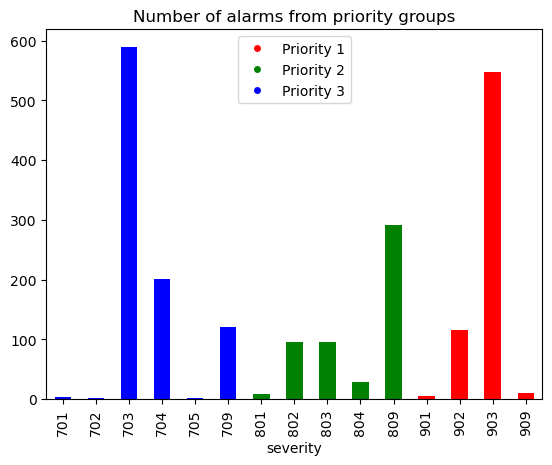

In [134]:
priority_colors = np.array([assign_color(pri) for pri in priority_count.index])
ax = priority_count.plot(kind="bar", title="Number of alarms from priority groups",
                           color=priority_colors[:,1])

unique_pri = np.unique(priority_colors, axis=0)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Priority {pri[0]}', markerfacecolor=col) for pri, col in zip(unique_pri[:,0], unique_pri[:,1])]
ax.legend(handles=legend_elements)

plt.show()

In [135]:
alarm_metadata["time"] = pd.to_datetime(alarm_events["start_time"], unit="ms").values
alarm_metadata = alarm_metadata.set_index("time").sort_index()

#### Group by severity

In [136]:
# alarm_metadata.groupby("Severity").resample("10T").count()
alarm_metadata_10min = alarm_metadata.resample("10T")
all_10mins = alarm_metadata_10min.count().index

# alarm_metadata_10min.get_group(datetime(2023,10,10,21,40)).groupby("Severity").count()
store_10min_counts = {idx:0 for idx in priority_count.index}
store_10min_counts = pd.DataFrame()
for d in all_10mins:
    list_severity = alarm_metadata_10min.get_group(d).groupby("Severity").count()["external_id"]
    df_severity = pd.DataFrame(list_severity).rename(columns={"external_id":"count"})
    df_severity = df_severity.reset_index()
    df_severity.index = [d]*len(df_severity)

    store_10min_counts = pd.concat([store_10min_counts, df_severity])

### 3. Group by priority

In [137]:
num_alarms_10min = alarm_metadata.groupby("PriorityLevel").resample("10T").count()["external_id"]
# test = test.rename(columns={"external_id":"count"})
num_alarms_10min = pd.DataFrame(num_alarms_10min, index=num_alarms_10min.index).sort_index(level="time")
num_alarms_10min = num_alarms_10min.rename(columns={"external_id":"count"})

### 4. Make table counting number of pri 1, 2 and 3 alarms each 10 min slot

In [201]:
num_alarms = pd.DataFrame(index=all_10mins)

for pri in [1,2,3]:
    num_alarms[f"priority {pri}"] = np.zeros(len(all_10mins))
    num_pri_alarms = num_alarms_10min[num_alarms_10min.index.get_level_values("PriorityLevel") == str(pri)]["count"]
    time_index = num_alarms_10min.index.get_level_values("time").unique()
    pri_index = time_index[time_index.isin(num_pri_alarms.index.get_level_values("time"))] # unique to omit duplicates from multiindex
    num_alarms.loc[num_alarms.index.isin(pri_index), f"priority {pri}"] = num_pri_alarms.values

    num_alarms[f"priority {pri}"].replace(np.nan, 0, inplace=True) # NaN means no alarms for this priority
    num_alarms[f"priority {pri}"] = num_alarms[f"priority {pri}"].astype(int) # from string to int

    num_alarms[f"pri{pri} / min"] = num_alarms[f"priority {pri}"]/10 # number of alarms of this priority per min for given 10 min period

    num_alarms[f"% of total pri{pri}"] = round(num_alarms[f"priority {pri}"]/num_alarms[f"priority {pri}"].sum()*100, 2) # percentage of all priority "pri" alarms last 12 hours occurred during 10 min period

num_alarms.head()

,priority 1,pri1 / min,% of total pri1,priority 2,pri2 / min,% of total pri2,priority 3,pri3 / min,% of total pri3
time,,,,,,,,,
2023-10-17 02:50:00,12,1.2,1.77,0,0.0,0.00,22,2.2,2.39
2023-10-17 03:00:00,7,0.7,1.03,0,0.0,0.00,7,0.7,0.76
2023-10-17 03:10:00,15,1.5,2.21,18,1.8,3.47,16,1.6,1.74
2023-10-17 03:20:00,9,0.9,1.33,0,0.0,0.00,17,1.7,1.85
2023-10-17 03:30:00,14,1.4,2.06,2,0.2,0.39,16,1.6,1.74


In [193]:
now = pd.Timestamp.now()
now_date = str(now.date()) + "_" + str(now.hour) + "h" + str(now.minute) + "m" + str(now.second) + "s"
num_alarms.to_csv(f"../data/output/num_alarms/last12hours_{now_date}.csv")

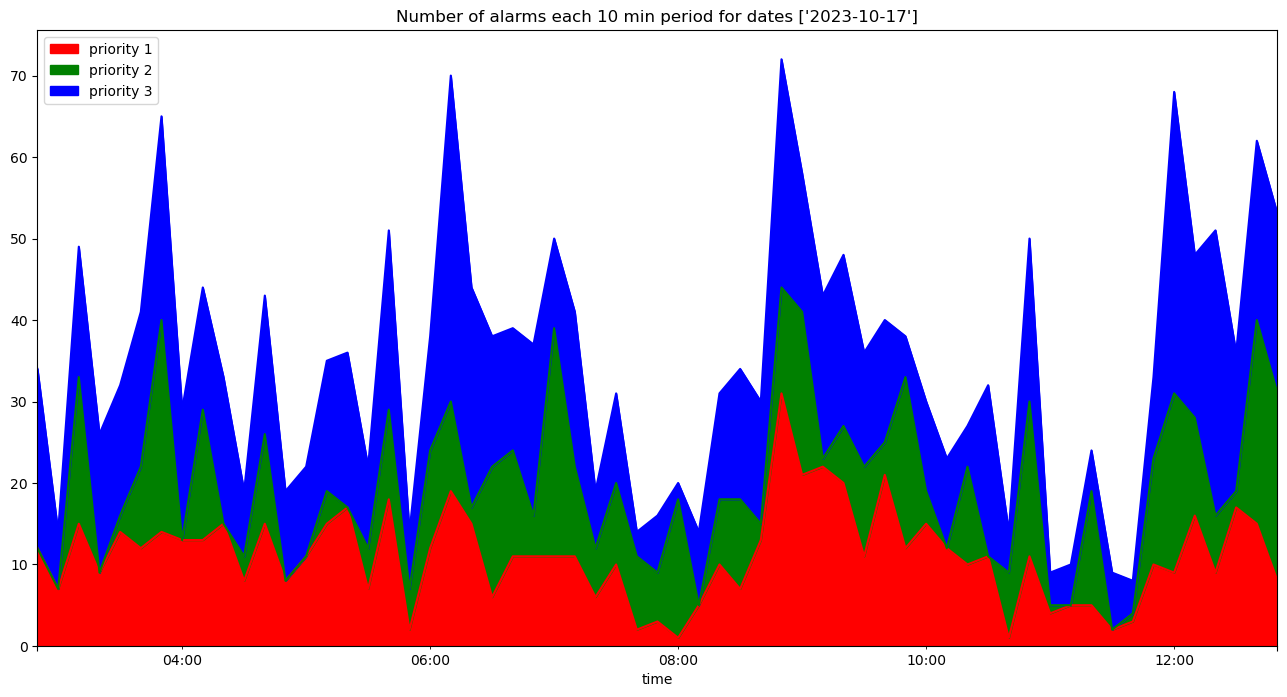

In [196]:
unique_dates = np.unique(pd.to_datetime(num_alarms.index).date)
num_alarms[["priority 1", "priority 2", "priority 3"]].plot.area(stacked=True,
                                                            figsize=[16,8], color=["r", "g", "b"],
                                                            title=f"Number of alarms each 10 min period for dates {[str(d) for d in unique_dates]}")

plt.show()

In [207]:
num_alarms.iloc[1:20]

,priority 1,pri1 / min,% of total pri1,priority 2,pri2 / min,% of total pri2,priority 3,pri3 / min,% of total pri3
time,,,,,,,,,
2023-10-17 03:00:00,7,0.7,1.03,0,0.0,0.00,7,0.7,0.76
2023-10-17 03:10:00,15,1.5,2.21,18,1.8,3.47,16,1.6,1.74
2023-10-17 03:20:00,9,0.9,1.33,0,0.0,0.00,17,1.7,1.85
2023-10-17 03:30:00,14,1.4,2.06,2,0.2,0.39,16,1.6,1.74
2023-10-17 03:40:00,12,1.2,1.77,10,1.0,1.93,19,1.9,2.07
2023-10-17 03:50:00,14,1.4,2.06,26,2.6,5.02,25,2.5,2.72
2023-10-17 04:00:00,13,1.3,1.91,0,0.0,0.00,16,1.6,1.74
2023-10-17 04:10:00,13,1.3,1.91,16,1.6,3.09,15,1.5,1.63
2023-10-17 04:20:00,15,1.5,2.21,0,0.0,0.00,18,1.8,1.96
